In [1]:
from sentence_transformers import SentenceTransformer
bmodel = SentenceTransformer('all-MiniLM-L6-v2')

In [2]:
import os
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk import FreqDist
import text2emotion as te
from LeXmo import LeXmo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\valla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\valla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\valla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
df = pd.read_csv('data/data.csv')



In [4]:
bert_embeddings = bmodel.encode(df['SpeechNormalize'])
bert_embeddings_std = scale(bert_embeddings)

E:\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
E:\Anaconda\lib\site-packages\sklearn\preprocessing\_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(


Text(0, 0.5, 'PCA 2')

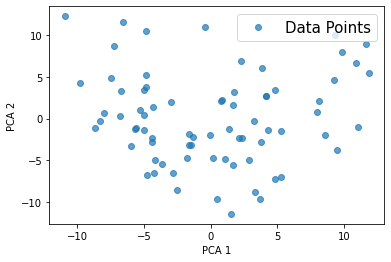

In [5]:
bert_embeddings_2data = PCA(n_components=2).fit_transform(bert_embeddings_std)
df_2D = pd.DataFrame(bert_embeddings_2data,columns=['PCA1', 'PCA2'])

plt.plot(df_2D.PCA1, df_2D.PCA2, 'o', alpha=0.7, label='Data Points')
# Tidy up plot
plt.legend(loc=0, fontsize=15)
plt.margins(0.05)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [6]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow = count_vect.fit_transform(df['SpeechNormalize'].values)
bow.shape

(74, 7737)

Text(0.5, 1.0, 'Elbow curve')

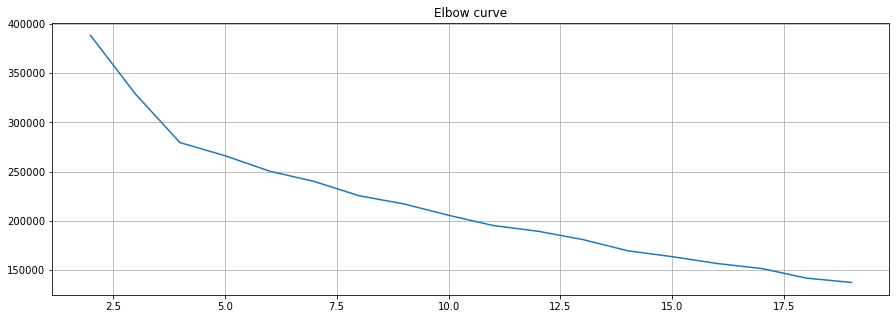

In [8]:
distorsions = []
for k in range(2, 20):
    model = KMeans(n_clusters = k)
    model.fit(bow)
    distorsions.append(model.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [9]:
model = KMeans(n_clusters = 8,init='k-means++',random_state=99)
model.fit(bert_embeddings_2data)
y_KMeans = model.predict(bert_embeddings_2data)

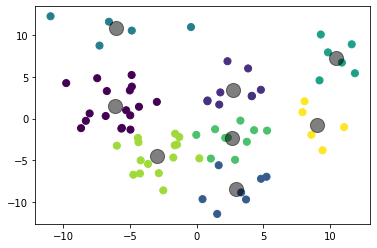

In [10]:
labels = model.labels_
cluster_center=model.cluster_centers_
plt.scatter(df_2D['PCA1'],df_2D['PCA2'], c=y_KMeans, s=50, cmap='viridis')
plt.scatter(cluster_center[:,0], cluster_center[:,1], c='black', s=200, alpha=0.5)

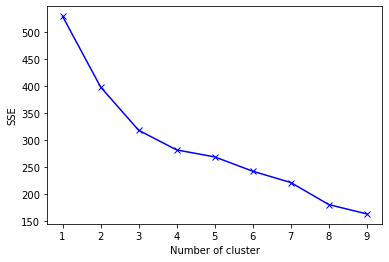

In [11]:
sse = {} 

for k in range(1, 10):
    kmedo = KMedoids(n_clusters=k, max_iter=1000, random_state=1).fit(bert_embeddings_2data)
    sse[k] = kmedo.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [12]:
model = KMedoids(n_clusters = 8,max_iter=1000, random_state=1)
model.fit(bert_embeddings_2data)
y_KMedoids = model.predict(bert_embeddings_2data)

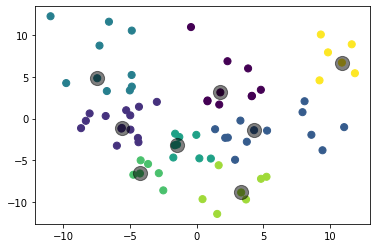

In [13]:
labels = model.labels_
cluster_center=model.cluster_centers_
plt.scatter(df_2D['PCA1'],df_2D['PCA2'], c=y_KMedoids, s=50, cmap='viridis')
plt.scatter(cluster_center[:,0], cluster_center[:,1], c='black', s=200, alpha=0.5)

K-Medoids is non sensitive to outliers and reduces noise as compared to K-Means as it minimizes the sum of dissimilarities of data objects. We used K-Medoids algorithm to perform the analysis.

In [14]:
cluster_center

array([[ 1.7709095,  3.1217227],
       [-5.618851 , -1.1235093],
       [ 4.3038487, -1.3873106],
       [-7.467643 ,  4.814468 ],
       [-1.47903  , -3.1026344],
       [-4.2610407, -6.5583367],
       [ 3.3328588, -8.825343 ],
       [10.892482 ,  6.679349 ]], dtype=float32)

In [15]:
# which tells us that clusters are far away from each other
from sklearn import metrics
silhouette_score = metrics.silhouette_score(bert_embeddings_2data, labels, metric='euclidean')
silhouette_score

0.38059148

In [16]:
# Giving Labels/assigning a cluster to each point/text 
df['Label'] = model.labels_ # the last column you can see the label numebers
df.head(10)

,Speech,Speech Word Frequency,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,NumWords,SpeechNormalize,Label
0,trump: wow. whoa. that group people. thousands...,<FreqDist with 922 samples and 2793 outcomes>,0.013828,0.033187,0.005992,0.013137,0.026043,0.027887,0.070754,0.014750,0.028578,0.042637,3443,trump wow whoa that group people thousands nic...,0
1,good evening. thank much speak today lifelong ...,<FreqDist with 608 samples and 1166 outcomes>,0.025760,0.046235,0.011889,0.035667,0.038309,0.044914,0.065390,0.025760,0.032365,0.058124,1273,good evening thank much speak today lifelong s...,0
2,"thank opportunity speak you, thank center nati...",<FreqDist with 948 samples and 1745 outcomes>,0.016202,0.039154,0.005851,0.027903,0.030603,0.054005,0.076058,0.013951,0.012601,0.055806,1911,thank opportunity speak you thank center natio...,2
3,thank joining today. this going speech hillary...,<FreqDist with 742 samples and 1539 outcomes>,0.038164,0.023724,0.015988,0.050542,0.013925,0.061888,0.051057,0.030944,0.011862,0.040227,1670,thank joining today this going speech hillary ...,7
4,today like share thoughts stakes election. peo...,<FreqDist with 877 samples and 1751 outcomes>,0.025103,0.041077,0.011410,0.031949,0.022364,0.052487,0.063441,0.026472,0.016431,0.053400,1891,today like share thoughts stakes election peop...,1
5,thank you like thank chairman jeff miller lead...,<FreqDist with 737 samples and 1305 outcomes>,0.021779,0.046582,0.013309,0.031458,0.028433,0.056866,0.097399,0.022384,0.019359,0.087719,1415,thank you like thank chairman jeff miller lead...,7
6,"thank you, everybody. great honor. great honor...",<FreqDist with 733 samples and 1805 outcomes>,0.015483,0.032477,0.006420,0.017749,0.023036,0.030967,0.074396,0.013973,0.019637,0.056269,2154,thank you everybody great honor great honor th...,0
7,"friends, delegates fellow americans humbly gra...",<FreqDist with 1195 samples and 2486 outcomes>,0.022850,0.040939,0.008886,0.035227,0.033957,0.052682,0.081561,0.027928,0.013012,0.065376,2699,friends delegates fellow americans humbly grat...,7
8,"donald trump, 235 days since crooked hillary c...",<FreqDist with 1158 samples and 4371 outcomes>,0.016393,0.028611,0.014692,0.017631,0.018095,0.033251,0.065728,0.019332,0.031395,0.036344,5193,donald trump days since crooked hillary clinto...,3
9,good? how good? special. special special man...,<FreqDist with 1233 samples and 3962 outcomes>,0.020491,0.039458,0.011177,0.026588,0.032007,0.041998,0.063167,0.022523,0.022185,0.045216,4747,good how good special special special man spec...,4


In [17]:
# How many points belong to each cluster -> using group by in pandas
df.groupby(['Label'])['SpeechNormalize'].count()

Label
0    10
1    14
2    13
3    10
4     8
5     6
6     7
7     6
Name: SpeechNormalize, dtype: int64

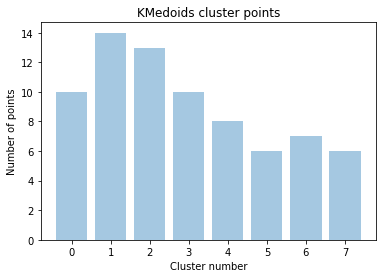

In [18]:
# visually how points or reviews are distributed across 8 clusters 
import matplotlib.pyplot as plt
plt.bar([x for x in range(8)], df.groupby(['Label'])['SpeechNormalize'].count(), alpha = 0.4)
plt.title('KMedoids cluster points')
plt.xlabel("Cluster number")
plt.ylabel("Number of points")
plt.show()

In [19]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS



def getClusterAnalysis(i):
    stopword_list = set(STOPWORDS) 
    
    
# Create a WordCloud object
    wordcloud = WordCloud(width=800, height=500, max_font_size=110, background_color="white", max_words=3000, 
                          contour_width=3, contour_color='steelblue', stopwords = stopword_list)

    all_words = ''.join([word for word in df[df['Label'] == i]['SpeechNormalize']]).replace('\n', '.')

    # Generate a word cloud
    wordcloud.generate(all_words)
    print('Total speechs ',df[df['Label'] == i]['SpeechNormalize'].shape[0])
    # Visualize the word cloud
    return wordcloud.to_image()

Total speechs  10


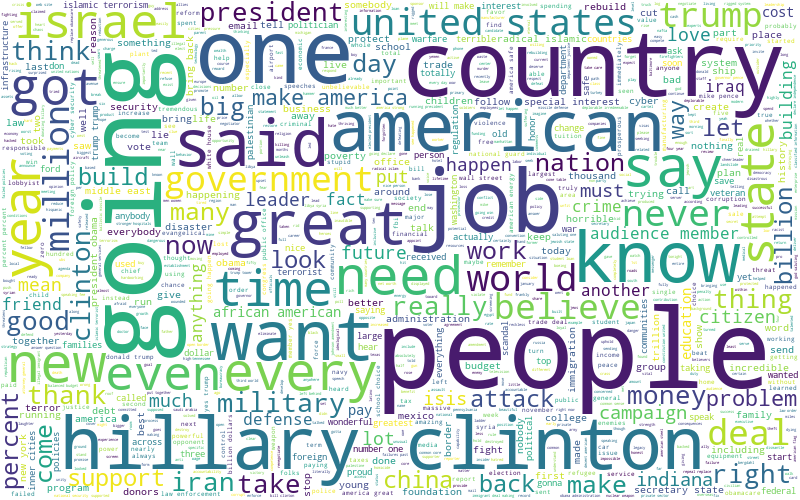

In [20]:
getClusterAnalysis(0)

Total speechs  14


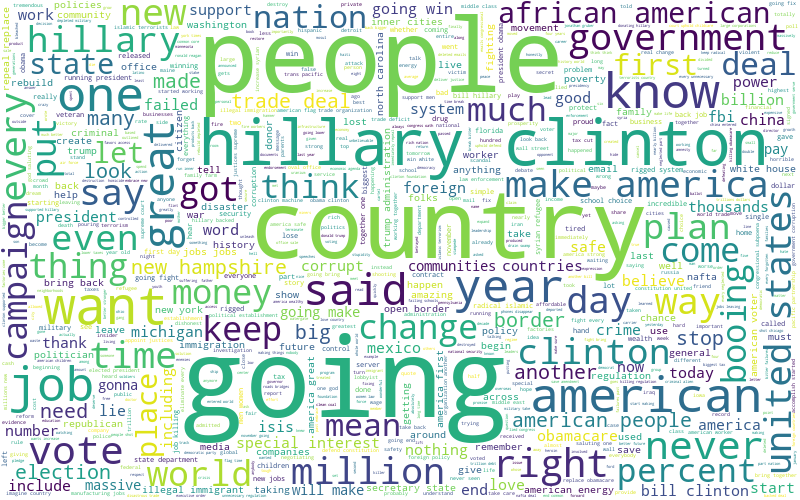

In [21]:
getClusterAnalysis(1)

Total speechs  13


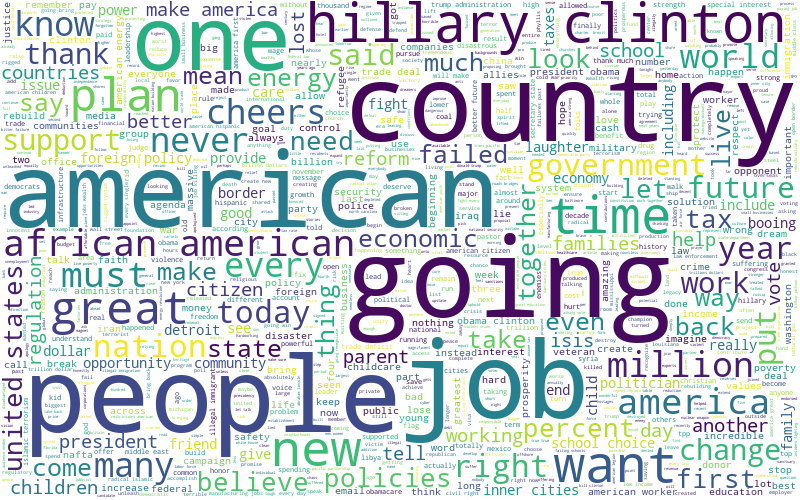

In [22]:
getClusterAnalysis(2)

Total speechs  10


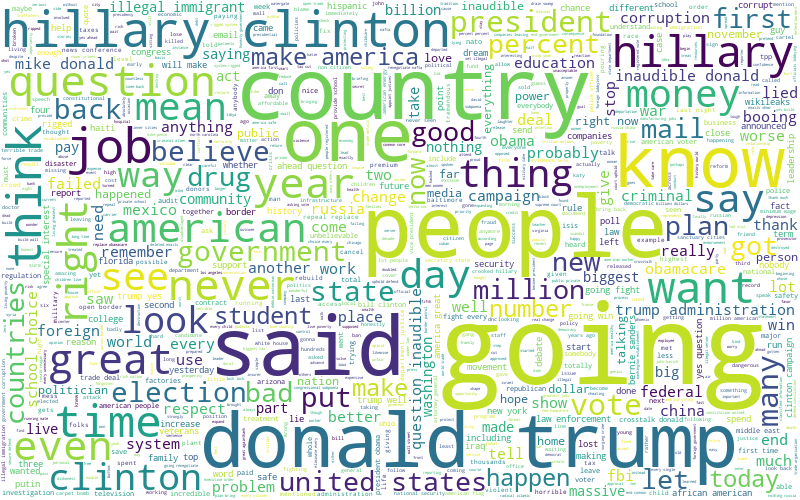

In [23]:
getClusterAnalysis(3)

Total speechs  8


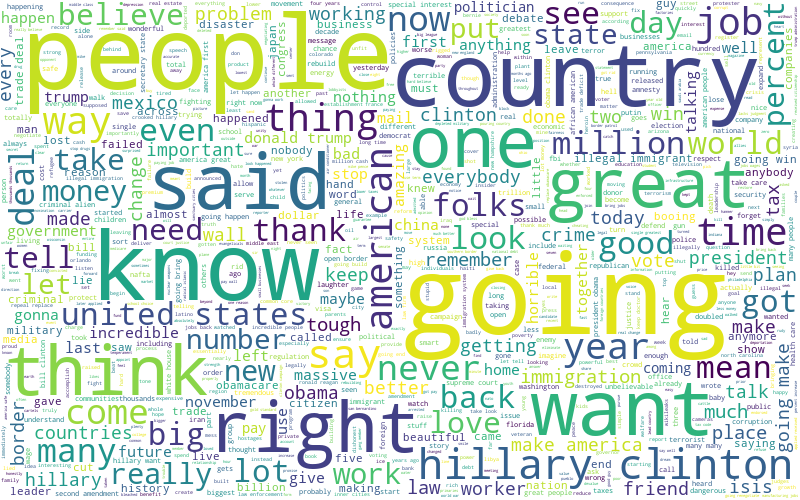

In [24]:
getClusterAnalysis(4)

Total speechs  6


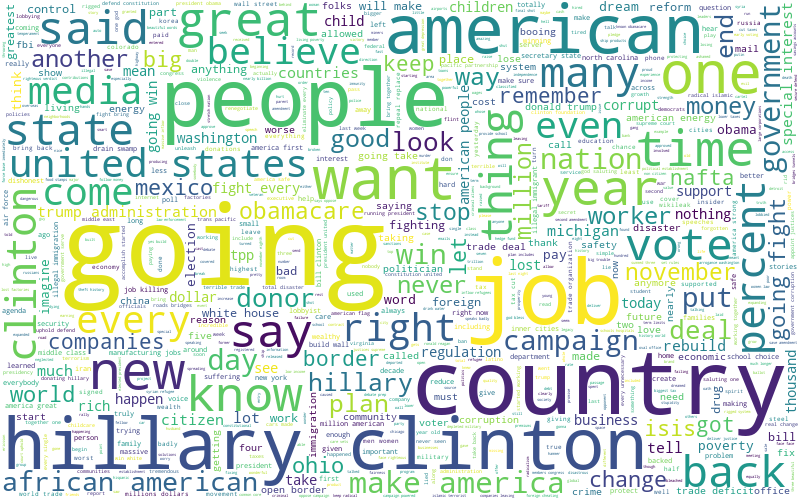

In [25]:
getClusterAnalysis(5)

Total speechs  7


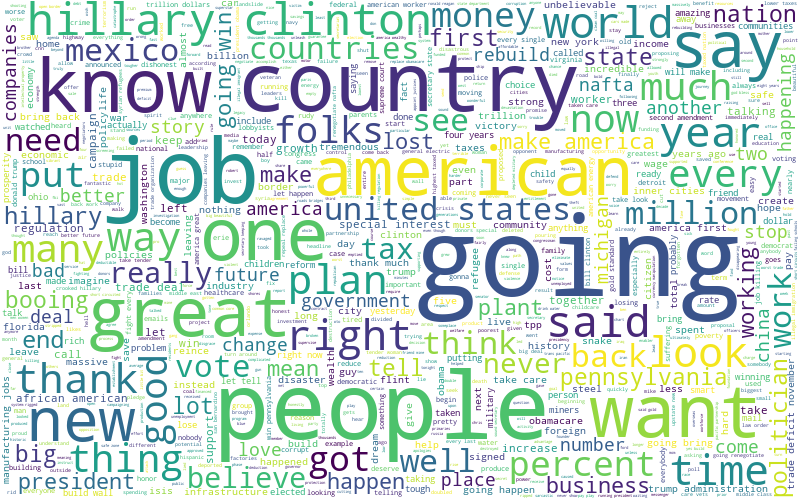

In [26]:
getClusterAnalysis(6)

Total speechs  6


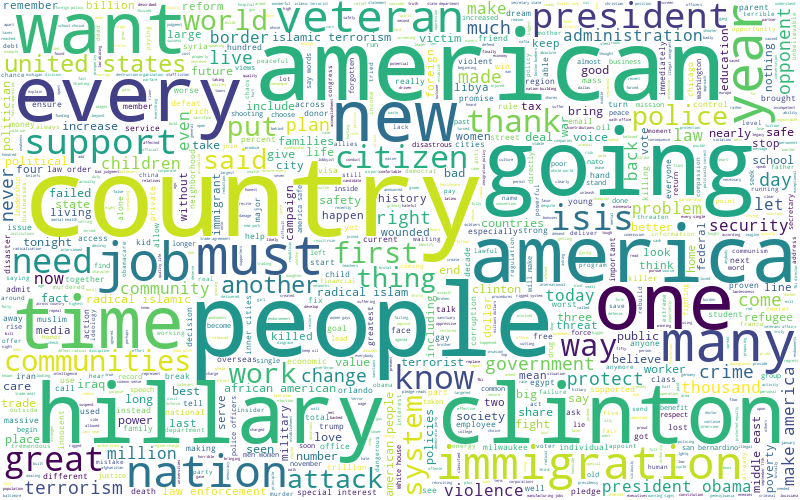

In [27]:
getClusterAnalysis(7)

In [28]:
df.to_csv('data/cluster.csv',index=False)